# Tasks

### 1. Implement the DQN algorithm and train an agent on the Pong environment.
- Change the input size of the CNN and use all 4 images as an input instead of blending them
together.
- Note that if you apply the crop function in the utilities, you’ll need to change the input
state size to 84x80 instead of 105x80.

### 2. Report the following metrics during training with the number of steps:
1. Score per episode
2. Average Cumulative reward of the last 5 episodes

### 3. Plot the deliberate change to the following parameters SEPARATELY and plot a figure of the
previous metrics for each change as follows:
– Plot figure with changing the mini-batch size: [8 (default), 16]
– Plot figure with changing the update rate of the target network to be every [3, 10 (default)]
episode

## Imports

In [1]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from assignment3_utils import process_frame
import matplotlib.pyplot as plt

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [ ]:


# ============================================================
# HYPERPARAMETERS
# ============================================================
GAMMA = 0.95 # Discount factor
LR = 1e-4 # Learning rate of the optimizer
BATCH_SIZE = 8  # Default mini-batch size
TARGET_UPDATE_EPISODES = 10 # Update target network every 10 episodes
EPS_INIT = 1.0  # Starting epsilon value (full exploration)
EPS_MIN = 0.05 # Minimum epsilon
EPS_DECAY = 0.995  # Epsilon decay rate per episode
REPLAY_MEMORY_SIZE = 50000  # Max replay buffer size
MIN_REPLAY_SIZE = 2000  # Start training after this many samples

IMAGE_SHAPE = (84, 80) # Input frame size after cropping/downsampling
STATE_STACK = 4  #Number of frames to stack (input channels)


# ============================================================
# CNN MODEL
# ============================================================
class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(STATE_STACK, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # Auto compute conv output size
        dummy = torch.zeros(1, STATE_STACK, IMAGE_SHAPE[0], IMAGE_SHAPE[1])
        conv_out = self.cnn(dummy).view(1, -1).size(1)

        #Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(conv_out, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# ============================================================
# Replay Buffer
# ============================================================
"""
    Stores past experiences (s, a, r, s') for learning.
    Allows random sampling for breaking correlation.
"""
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def push(self, exp):
        self.buffer.append(exp) # Store a single experience tuple

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.uint8),
        )

    def __len__(self):
        return len(self.buffer)


# ============================================================
# Frame Stack Helper
# ============================================================\
"""
    Keeps a queue of the last 4 frames.
    Ensures the CNN sees motion (important for Pong).
"""
def stack_frames(stacked, frame):
    stacked.append(frame)
    # If fewer than 4 frames, repeat the first frame
    if len(stacked) < STATE_STACK:
        for _ in range(STATE_STACK - len(stacked)):
            stacked.append(frame)
    # Return stacked state with shape (4, 84, 80)
    return np.stack(stacked, axis=0), stacked


# ============================================================
# TRAINING LOOP
# ============================================================
def train_dqn(batch_size=BATCH_SIZE, target_update_rate=TARGET_UPDATE_EPISODES):

    # Create Pong environment
    env = gym.make("PongDeterministic-v4")
    num_actions = env.action_space.n

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Main Q-network and target Q-network
    policy_net = DQN(num_actions).to(device)
    target_net = DQN(num_actions).to(device)

    # Initialize target network weights
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    replay = ReplayBuffer(REPLAY_MEMORY_SIZE)

    epsilon = EPS_INIT
    episode_rewards = []
    avg_last5 = []

     # Loop for 200 episodes
    for episode in range(1, 201):
        # Reset environment, get first observation
        obs = env.reset()[0]
        frame = process_frame(obs, IMAGE_SHAPE).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

        # Initialize stacked frames
        stacked_frames = deque(maxlen=STATE_STACK)
        state, stacked_frames = stack_frames(stacked_frames, frame)

        done = False
        total_reward = 0

        # Run episode
        while not done:

            # Epsilon-greedy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    # Convert state to tensor (1, 4, 84, 80)
                    s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = policy_net(s).argmax(dim=1).item() # Exploit

            # Step in environment
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Reward shaping: convert Pong rewards to -1, 0, +1
            reward = np.sign(reward)
            total_reward += reward

            # Preprocess next frame
            next_frame = process_frame(next_obs, IMAGE_SHAPE).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

            # Stack next state
            next_state, stacked_frames = stack_frames(stacked_frames, next_frame)

            # Store experience in replay memory
            replay.push((state, action, reward, next_state, done))
            state = next_state

            # Start training when replay has enough samples
            if len(replay) > MIN_REPLAY_SIZE:
                # Sample mini-batch
                states, actions, rewards, next_states, dones = replay.sample(batch_size)
                # Convert to PyTorch tensors
                states = torch.tensor(states, dtype=torch.float32).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
                actions = torch.tensor(actions).to(device)
                rewards = torch.tensor(rewards).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).to(device)
                # Q(s,a) from the policy net
                q_pred = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
                # Q(s',a') from target net
                with torch.no_grad():
                    q_next = target_net(next_states).max(dim=1)[0]
                    q_target = rewards + GAMMA * q_next * (1 - dones)
                # Compute loss (MSE)
                loss = nn.MSELoss()(q_pred, q_target)
                # Backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if episode % target_update_rate == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Epsilon decay
        epsilon = max(EPS_MIN, epsilon * EPS_DECAY)

        # Logging
        episode_rewards.append(total_reward)
        avg = np.mean(episode_rewards[-5:])
        avg_last5.append(avg)

        print(f"Episode {episode} | Score: {total_reward} | Avg5: {avg:.2f} | Eps: {epsilon:.3f}")

    env.close()
    return episode_rewards, avg_last5


## Experiment 1 — Batch Size 8 vs 16

Running baseline (batch = 8)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/turtle/Downloads/RL/Assignment3/rl_env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1 | Score: -21.0 | Avg5: -21.00 | Eps: 0.995
Episode 2 | Score: -21.0 | Avg5: -21.00 | Eps: 0.990
Episode 3 | Score: -21.0 | Avg5: -21.00 | Eps: 0.985
Episode 4 | Score: -20.0 | Avg5: -20.75 | Eps: 0.980
Episode 5 | Score: -21.0 | Avg5: -20.80 | Eps: 0.975
Episode 6 | Score: -21.0 | Avg5: -20.80 | Eps: 0.970
Episode 7 | Score: -21.0 | Avg5: -20.80 | Eps: 0.966
Episode 8 | Score: -19.0 | Avg5: -20.40 | Eps: 0.961
Episode 9 | Score: -21.0 | Avg5: -20.60 | Eps: 0.956
Episode 10 | Score: -18.0 | Avg5: -20.00 | Eps: 0.951
Episode 11 | Score: -20.0 | Avg5: -19.80 | Eps: 0.946
Episode 12 | Score: -21.0 | Avg5: -19.80 | Eps: 0.942
Episode 13 | Score: -18.0 | Avg5: -19.60 | Eps: 0.937
Episode 14 | Score: -20.0 | Avg5: -19.40 | Eps: 0.932
Episode 15 | Score: -21.0 | Avg5: -20.00 | Eps: 0.928
Episode 16 | Score: -20.0 | Avg5: -20.00 | Eps: 0.923
Episode 17 | Score: -21.0 | Avg5: -20.00 | Eps: 0.918
Episode 18 | Score: -19.0 | Avg5: -20.20 | Eps: 0.914
Episode 19 | Score: -20.0 | Avg5: -20

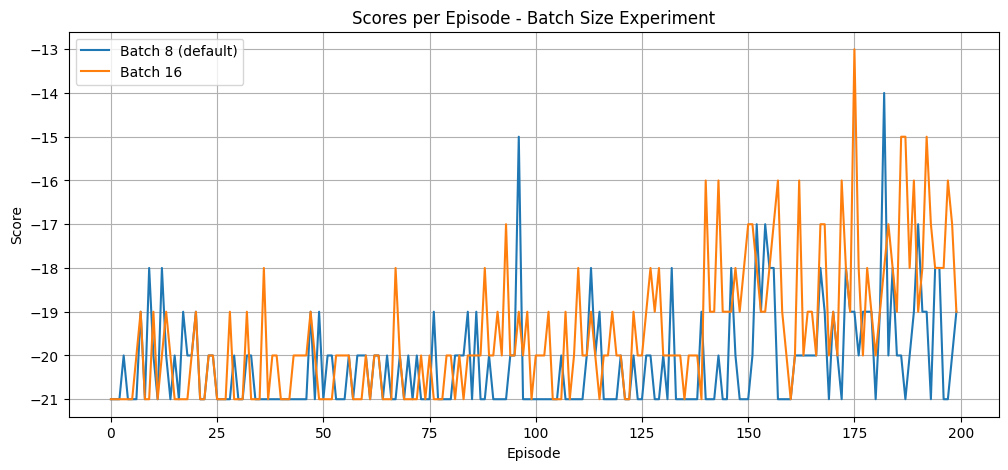

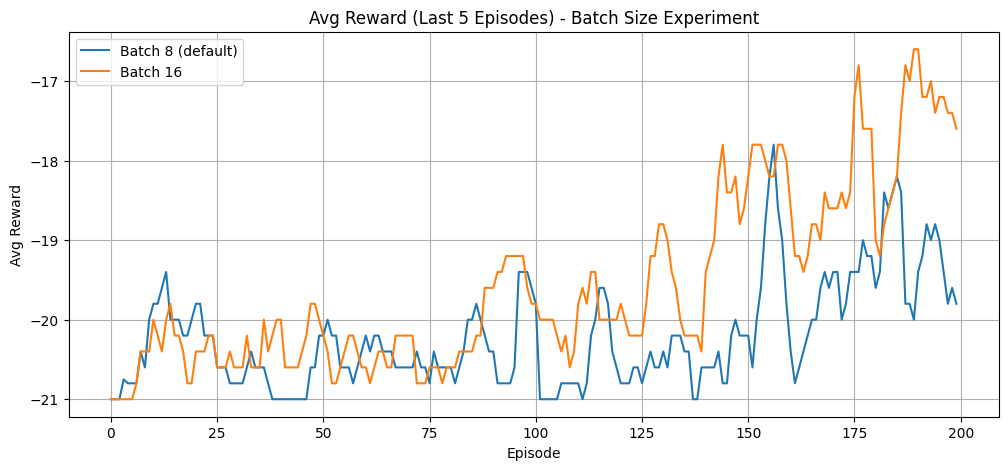

In [3]:
print("Running baseline (batch = 8)")
rewards_8, avg8 = train_dqn(batch_size=8)

print("Running experiment (batch = 16)")
rewards_16, avg16 = train_dqn(batch_size=16)

# Plot Scores
plt.figure(figsize=(12,5))
plt.plot(rewards_8, label="Batch 8 (default)")
plt.plot(rewards_16, label="Batch 16")
plt.title("Scores per Episode - Batch Size Experiment")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

# Plot Avg Last 5
plt.figure(figsize=(12,5))
plt.plot(avg8, label="Batch 8 (default)")
plt.plot(avg16, label="Batch 16")
plt.title("Avg Reward (Last 5 Episodes) - Batch Size Experiment")
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.legend()
plt.grid()
plt.show()


# Target Network Update Rate 10 vs 3

Running baseline (target update = 10)
Episode 1 | Score: -20.0 | Avg5: -20.00 | Eps: 0.995
Episode 2 | Score: -20.0 | Avg5: -20.00 | Eps: 0.990
Episode 3 | Score: -21.0 | Avg5: -20.33 | Eps: 0.985
Episode 4 | Score: -20.0 | Avg5: -20.25 | Eps: 0.980
Episode 5 | Score: -21.0 | Avg5: -20.40 | Eps: 0.975
Episode 6 | Score: -19.0 | Avg5: -20.20 | Eps: 0.970
Episode 7 | Score: -20.0 | Avg5: -20.20 | Eps: 0.966
Episode 8 | Score: -21.0 | Avg5: -20.20 | Eps: 0.961
Episode 9 | Score: -21.0 | Avg5: -20.40 | Eps: 0.956
Episode 10 | Score: -21.0 | Avg5: -20.40 | Eps: 0.951
Episode 11 | Score: -21.0 | Avg5: -20.80 | Eps: 0.946
Episode 12 | Score: -21.0 | Avg5: -21.00 | Eps: 0.942
Episode 13 | Score: -21.0 | Avg5: -21.00 | Eps: 0.937
Episode 14 | Score: -21.0 | Avg5: -21.00 | Eps: 0.932
Episode 15 | Score: -21.0 | Avg5: -21.00 | Eps: 0.928
Episode 16 | Score: -19.0 | Avg5: -20.60 | Eps: 0.923
Episode 17 | Score: -20.0 | Avg5: -20.40 | Eps: 0.918
Episode 18 | Score: -21.0 | Avg5: -20.40 | Eps: 0.914

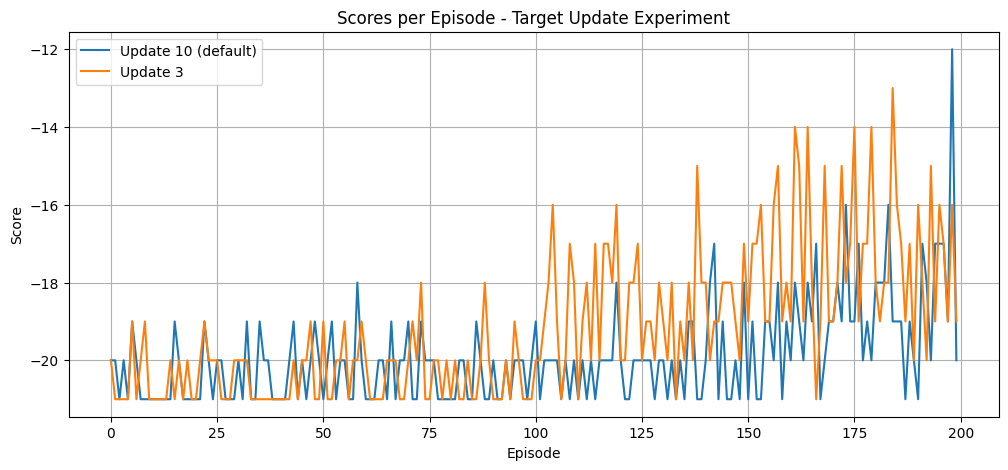

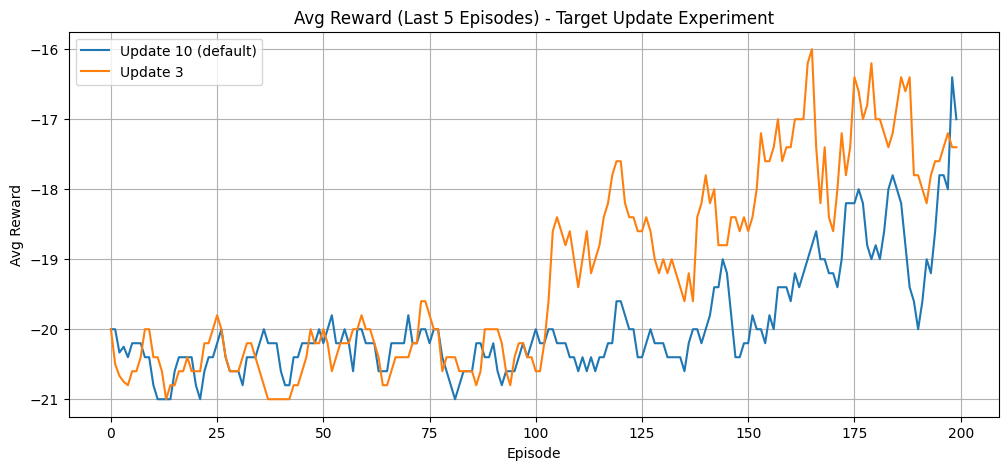

In [4]:
print("Running baseline (target update = 10)")
rewards_10, avg10 = train_dqn(target_update_rate=10)

print("Running experiment (target update = 3)")
rewards_3, avg3 = train_dqn(target_update_rate=3)

# Plot Scores
plt.figure(figsize=(12,5))
plt.plot(rewards_10, label="Update 10 (default)")
plt.plot(rewards_3, label="Update 3")
plt.title("Scores per Episode - Target Update Experiment")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

# Plot Avg Last 5
plt.figure(figsize=(12,5))
plt.plot(avg10, label="Update 10 (default)")
plt.plot(avg3, label="Update 3")
plt.title("Avg Reward (Last 5 Episodes) - Target Update Experiment")
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.legend()
plt.grid()
plt.show()
